In [1]:
# Bee Hive data https://drive.google.com/file/d/142IBcs6OyQiJxO7owPfkEBFbkrudnh0g/view?usp=sharing

In [2]:
APP = "BeeHive"

In [3]:
# Install a pip package in the current Jupyter kernel
!{sys.executable} -m pip install -e '../../../Wielder/'
!{sys.executable} -m pip install -e '../'

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


In [4]:
from pep_data.project import get_project_conf

conf = get_project_conf()

app_conf = conf[APP]
# print(conf)

('why_does_a_chicken', "I don't know why")
('BeeHive', ConfigTree([('raw_col_names', ['remove', 'Bee ID', 'remove1', 'DaughtersEfficiencyScore', 'remove2', 'Father SIZE', 'Father TYPE', 'remove3', 'X', 'Y', 'Z']), ('double_cols', ['DaughtersEfficiencyScore', 'X', 'Y', 'Z']), ('integer_cols', ['Father SIZE'])]))
('moto', 'who dares, wins!')


In [5]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType
from pyspark.sql import functions as f

In [6]:
spark = SparkSession.builder.appName(APP).getOrCreate()

22/10/13 10:45:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
from pep_data.spark.util import field_to_struct

#Create schema for the data

raw_col_names = app_conf['raw_col_names']
double_cols = app_conf['double_cols']
integer_cols = app_conf['integer_cols']


# Create all the fields
fields = [field_to_struct(header, doubles=double_cols, integers=integer_cols) for header in raw_col_names]

# Create the schema from th e fields
schema = StructType(fields)

In [8]:
# Read the data from the csv using the schema
df = spark.read.schema(schema).csv('Downloads/BeeHiveTestData.csv')

df.show(5)

+------+------+--------------------+------------------------+-----------------+-----------+-----------+---------+-----------+-----------+-----------+
|remove|Bee ID|             remove1|DaughtersEfficiencyScore|          remove2|Father SIZE|Father TYPE|  remove3|          X|          Y|          Z|
+------+------+--------------------+------------------------+-----------------+-----------+-----------+---------+-----------+-----------+-----------+
|Bee ID|   0_0|DaughtersEfficien...|           -0.1647494899|Father SIZE&TYPE:|          5|     107027|Locus XYZ|   5.345708|25.54008605|24.79858692|
|Bee ID|   0_9|DaughtersEfficien...|          -0.09111780618|Father SIZE&TYPE:|          8|      35473|Locus XYZ| 3.61617713|15.39993678|14.11150683|
|Bee ID|  0_16|DaughtersEfficien...|           -0.2783737487|Father SIZE&TYPE:|          9|      72732|Locus XYZ|6.487132473|27.96111467|23.50405554|
|Bee ID|  0_76|DaughtersEfficien...|           0.01988315069|Father SIZE&TYPE:|          6|      490

In [9]:
cols_to_keep = [x for x in df.columns if 'remove' not in x]
df = df.select(*cols_to_keep)

df.show(5)

+------+------------------------+-----------+-----------+-----------+-----------+-----------+
|Bee ID|DaughtersEfficiencyScore|Father SIZE|Father TYPE|          X|          Y|          Z|
+------+------------------------+-----------+-----------+-----------+-----------+-----------+
|   0_0|           -0.1647494899|          5|     107027|   5.345708|25.54008605|24.79858692|
|   0_9|          -0.09111780618|          8|      35473| 3.61617713|15.39993678|14.11150683|
|  0_16|           -0.2783737487|          9|      72732|6.487132473|27.96111467|23.50405554|
|  0_76|           0.01988315069|          6|      49069|8.285176906|21.88111447|10.80561155|
|  0_35|           -0.0758420403|          5|        187|       -1.0|       13.0|       17.0|
+------+------------------------+-----------+-----------+-----------+-----------+-----------+
only showing top 5 rows



In [10]:
# Create a data frame with the best bee (lowest DaughtersEfficiencyScore) for each Father SIZE
df_min_efficient = df\
    .join(df.groupBy('Father SIZE')
    .agg(f
         .min('DaughtersEfficiencyScore')
         .alias('DaughtersEfficiencyScore')), on='DaughtersEfficiencyScore', how='leftsemi')

df_min_efficient.show()

+------------------------+-------+-----------+-----------+-----+-----------+-----------+
|DaughtersEfficiencyScore| Bee ID|Father SIZE|Father TYPE|    X|          Y|          Z|
+------------------------+-------+-----------+-----------+-----+-----------+-----------+
|            -1.251419554|18_2782|         15|        107|1.735|     25.272|     26.084|
|           -0.9895374723|31_1686|         13|      37820|3.893|     24.131|     25.916|
|            -3.304824801|34_1173|          5|      20521|4.293|     26.131|     26.716|
|            -1.811097054|32_1252|         10|      90500|3.743|     24.281|     25.866|
|            -1.957777867|38_1162|          7|       5451|3.993|     25.931|     26.116|
|            -1.428105272|49_1958|         11|     106378|3.656|26.21443432|26.39561173|
|            -1.542647722|51_4647|          9|      60100|3.387|     26.196|     24.716|
|            -2.373956582|52_1751|          6|     119442|2.543|     24.581|     24.866|
|            -1.30310

In [11]:
# Convert from pyspark data frame to pandas data frame
df_cleaned_pd = df_min_efficient.toPandas()

df_cleaned_pd

,DaughtersEfficiencyScore,Bee ID,Father SIZE,Father TYPE,X,Y,Z
0,-1.251420,18_2782,15,107,1.735,25.272000,26.084000
1,-0.989537,31_1686,13,37820,3.893,24.131000,25.916000
2,-3.304825,34_1173,5,20521,4.293,26.131000,26.716000
3,-1.811097,32_1252,10,90500,3.743,24.281000,25.866000
4,-1.957778,38_1162,7,5451,3.993,25.931000,26.116000
5,-1.428105,49_1958,11,106378,3.656,26.214434,26.395612
6,-1.542648,51_4647,9,60100,3.387,26.196000,24.716000
7,-2.373957,52_1751,6,119442,2.543,24.581000,24.866000
8,-1.303101,65_384,14,2127,3.641,24.882000,26.269000
9,-2.004108,84_2144,12,50772,3.040,26.543000,26.346000


In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

<IPython.core.display.Javascript object>


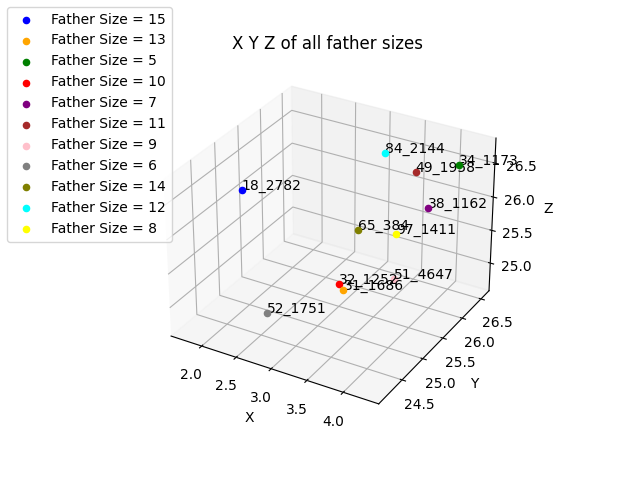

In [13]:
# Create scatter plot based on bees location with text annotation over data point

# Colors for bee groups (groups of Father SIZE)
colors = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow')

# Number of rows in the data frame
length = len(df_cleaned_pd.index)

# Create plot figure
fig = plt.figure()

# Create 3D axes
ax = plt.axes(projection='3d')

for i in range (length):
    
    # Create dot on graph with color and label
    ax.scatter3D(df_cleaned_pd['X'][i], df_cleaned_pd['Y'][i], df_cleaned_pd['Z'][i],
            c = colors[i], label = f"Father Size = {df_cleaned_pd['Father SIZE'][i]}")
    
    # Add text(Bee_ID) for dot
    ax.text(df_cleaned_pd['X'][i], df_cleaned_pd['Y'][i], df_cleaned_pd['Z'][i], 
            '%s' % (df_cleaned_pd['Bee ID'][i]), size=10)

# Add Plot Title
ax.set_title('X Y Z of all father sizes')

# Set x axis name
ax.set_xlabel('X')

# Set y axis name
ax.set_ylabel('Y')

#Set z axis name
ax.set_zlabel('Z')

# Create legend(descriptive labels for each plotted data series)
fig.legend(loc="upper left")

# Show plot, not necessary but used to remove unwanted output
plt.show()

In [14]:
import numpy as np

In [15]:
# Convert from pyspark data frame to numpy array
df_cleaned_np = np.array(df_min_efficient.select("X", "Y", "Z").collect())

df_cleaned_np

array([[ 1.735     , 25.272     , 26.084     ],
       [ 3.893     , 24.131     , 25.916     ],
       [ 4.293     , 26.131     , 26.716     ],
       [ 3.743     , 24.281     , 25.866     ],
       [ 3.993     , 25.931     , 26.116     ],
       [ 3.656     , 26.21443432, 26.39561173],
       [ 3.387     , 26.196     , 24.716     ],
       [ 2.543     , 24.581     , 24.866     ],
       [ 3.641     , 24.882     , 26.269     ],
       [ 3.04      , 26.543     , 26.346     ],
       [ 3.695     , 25.689     , 25.783     ]])

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

In [17]:
# Create scatter plot based on bees location with text annotation over data point closest to mouse

def visualize3DData (df_cleaned_np):
    """Visualize data in 3d plot with popover next to mouse position.

    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
    Returns:
        None
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range (length):
        ax.scatter3D(df_cleaned_pd['X'][i], df_cleaned_pd['Y'][i], df_cleaned_pd['Z'][i],
            c = colors[i], label = f"Father Size = {df_cleaned_pd['Father SIZE'][i]}", depthshade = False, picker = True)



    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (3,), "distance: point.shape is wrong: %s, must be (3,)" % point.shape

        # Project 3d data space to 2d data space
        x2, y2, _ = proj3d.proj_transform(point[0], point[1], point[2], plt.gca().get_proj())
        # Convert 2d data space to 2d screen space
        x3, y3 = ax.transData.transform((x2, y2))

        return np.sqrt ((x3 - event.x)**2 + (y3 - event.y)**2)


    def calcClosestDatapoint(df_cleaned_np, event):
        """"Calculate which data point is closest to the mouse position.

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (df_cleaned_np[i, 0:3], event) for i in range(df_cleaned_np.shape[0])]
        return np.argmin(distances)


    def annotatePlot(df_cleaned_np, index):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        # If we have previously displayed another label, remove it first
        if hasattr(annotatePlot, 'label'):
            annotatePlot.label.remove()
        # Get data point from array of points X, at position index
        x2, y2, _ = proj3d.proj_transform(df_cleaned_np[index, 0], df_cleaned_np[index, 1], df_cleaned_np[index, 2], ax.get_proj())
        annotatePlot.label = plt.annotate( "Bee ID = %s" % df_cleaned_pd['Bee ID'][index],
            xy = (x2, y2), xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        fig.canvas.draw()


    def onMouseMotion(event):
        """Event that is triggered when mouse is moved. Shows text annotation over data point closest to mouse."""
        closestIndex = calcClosestDatapoint(df_cleaned_np, event)
        annotatePlot (df_cleaned_np, closestIndex)

    fig.canvas.mpl_connect('motion_notify_event', onMouseMotion)  # on mouse motion
    plt.show()




<IPython.core.display.Javascript object>


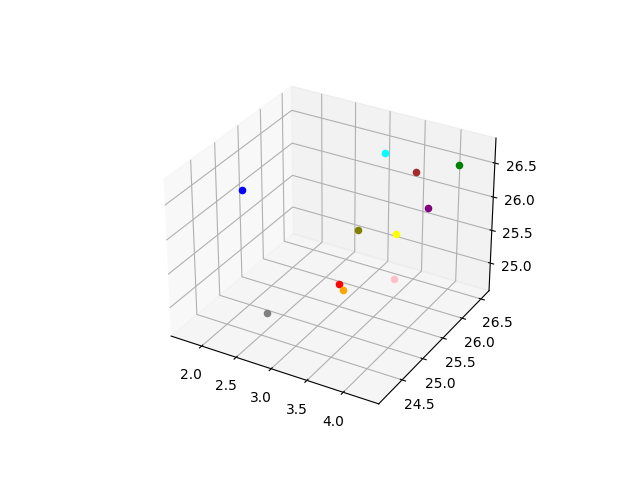

In [18]:
visualize3DData (df_cleaned_np)